# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
# Импорт библиотеки машинное обучение
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix,
                             recall_score, precision_score, f1_score)
from tqdm import tqdm

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

In [3]:
def review(df):
    info = display(df.head()), df.info(), 
    print('-'*50), 
    print('Количчество дубликатов:',df.duplicated().sum()),
    pd.options.display.float_format = '{:,.2f}'.format
    display(df.describe())

In [4]:
# Изучим в целом данные нашего датафрейма
review(df)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
--------------------------------------------------
Количчество дубликатов: 0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


In [5]:
# Приведем столбцы к нижнему регистру и переименнуем коллоны для удобства
df.columns = df.columns.str.lower()
df.rename(columns={
    'rownumber':'row_number',
    'customerid':'customer_id',
    'creditscore':'credit_score',
    'numofproducts':'num_of_product',
    'hascrcard':'has_cr_card',
    'isactivemember':'is_active_member',
    'estimatedsalary':'estimated_salary'
},
          inplace=True)
# Проверяем преобразование
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_product    10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# Выведем данные по пропускам
df[df.tenure.isnull()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_product,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,"140,469.38",1
48,49,15766205,Yin,550,Germany,Male,38,NaN,"103,391.38",1,0,1,"90,878.13",0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,"146,050.97",2,0,0,"86,424.57",0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,"125,561.97",1,0,0,"164,040.94",1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,"136,857.00",1,0,0,"84,509.57",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,"190,409.34",2,1,1,"138,361.48",0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,"85,216.61",1,1,0,"117,369.52",1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,"117,593.48",2,0,0,"113,308.29",0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,"123,841.49",2,1,0,"96,833.00",0


In [7]:
# Заполним пустые значение медианным значеием
df.tenure = df.tenure.fillna(df.tenure.median())
print(f'Количество уникальных значений: {df.tenure.unique()}')
print(f'Количество пустых значий: {df.tenure.isnull().sum()}')

Количество уникальных значений: [ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0.]
Количество пустых значий: 0


Мы заполнили пустые значения медианным для дальнейшего анализа датафрейма

In [8]:
# Проверим уникальные значения в двух позициях для анализа
print(df.geography.value_counts())
print(df.gender.value_counts())

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
Male      5457
Female    4543
Name: gender, dtype: int64


Уникальных значений в этих столбцах немного, поэтому нам можно их закодировать методом One-Hot Encoding (OHE).

In [9]:
df = pd.get_dummies(df,
                    columns=['geography', 'gender'],
                    drop_first=True)

In [10]:
# Выделим из датасета целевой признак Exited и избавимся от лишних данных.
features = df.drop(['row_number', 'customer_id', 'surname', 'exited'], axis=1)
target = df.exited

**Разобьем данные на выборки и проведем масштабирование**

In [11]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345) 

In [12]:
numeric = ['age','tenure','balance','credit_score','num_of_product','estimated_salary']

In [13]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [14]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

/tmp/ipykernel_63/3679938634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [15]:
# проверим прошло ли масштабирование
features_train

,credit_score,age,tenure,balance,num_of_product,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,-0.89,-0.37,1.08,1.23,-0.89,1,0,-0.19,0,1,1
3411,0.61,-0.18,1.08,0.60,-0.89,0,0,-0.33,0,0,0
6027,2.05,0.48,-0.74,1.03,0.83,0,1,1.50,1,0,1
1247,-1.46,-1.42,0.35,-1.23,0.83,1,0,-1.07,0,0,1
3716,0.13,-1.13,-1.10,1.14,-0.89,0,0,1.52,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.07,-0.75,-0.37,-1.23,0.83,0,1,-1.28,0,0,1
4094,-1.45,-0.94,1.81,-1.23,0.83,0,1,-1.28,0,0,1
3492,0.03,0.58,-0.01,-0.31,-0.89,0,1,-0.90,0,0,0
2177,0.15,-1.42,-0.37,-1.23,0.83,0,1,-1.13,0,0,0


In [16]:
print('Shapes\nTraining set: {}\n              {}'
  .format(features_train.shape,target_train.shape))
print('Shapes\nValid set:    {}\n              {}'
  .format(features_valid.shape,target_valid.shape))
print('Shapes\nTest set:     {}\n              {}'
  .format(features_test.shape,target_test.shape))

Shapes
Training set: (6000, 11)
              (6000,)
Shapes
Valid set:    (2000, 11)
              (2000,)
Shapes
Test set:     (2000, 11)
              (2000,)


## Исследование задачи

Целевой признак - exited, который может принимать значения 1 или 0, что отражает факт ухода клиента из банка. Перед нами задача бинарной классификации. Проверим насколько сбалансированы классы в выборке.

In [17]:
target_train.value_counts(normalize=True).round(3) * 100

0   80.10
1   19.90
Name: exited, dtype: float64

Соотношение классов 19.90 - 80.10 Классы не являются сбалансированными. Обучим модели на несбалансированной выборке и получим метрики таких моделей. В качестве алгоритмов обучения используем Random Forest Classifier и Logistic Regression. На несбалансированной выборке будем использовать метрику F1, как определяющую качество модели.

**Random Forest**

In [18]:
%%time
for depth in tqdm(range(1, 25, 3)):
    for est in range(1, 100, 10):
        model_rfc = RandomForestClassifier(random_state=12345,
                                               n_estimators=est,
                                               max_depth=depth)
        model_rfc.fit(features_train, target_train)
        predicted_valid_rfc = model_rfc.predict(features_valid)
        result_rfc = f1_score(target_valid, predicted_valid_rfc)
        roc_auc_rfc = roc_auc_score(target_valid, predicted_valid_rfc)
print(
'''
best_est       = {}
best max_depth = {}
best result F1 = {:,.4f}
best AUC-ROC   = {:,.4f}'''
        .format(est, depth, result_rfc, roc_auc_rfc))

100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


best_est       = 91
best max_depth = 22
best result F1 = 0.5888
best AUC-ROC   = 0.7194
CPU times: user 19.2 s, sys: 37.9 ms, total: 19.2 s
Wall time: 19.3 s


Максимальное значение F1 - 0.5888, достигнуто при количестве деревьев 91 и их максимальной глубине 22.

**LogisticRegression**

Получим результат для модели с алгоритмом обучения Logistic Regression.

In [19]:
model_lgr = LogisticRegression(random_state = 12345, solver='liblinear')
model_lgr.fit(features_train, target_train)

predicted_valid_lgr = model_lgr.predict(features_valid)

result_lgr = f1_score(target_valid, predicted_valid_lgr)
roc_auc = roc_auc_score(target_valid, predicted_valid_lgr)

print('''
F1      = {:,.4f}
AUC-ROC = {:,.4f}'''.format(result_lgr, roc_auc))


F1      = 0.3311
AUC-ROC = 0.5932


Метрика F1 линейной модели значительно хуже, чем у случайного леса.

Метрика F1 лучше у модели с алгоритмом Random Forest с гиперпараметрами количество оценщиков 91 и глубиной деревьев 22. Создадим таблицу scores и запишем в нее полученное значения F1 на валидационной выборки.

In [20]:
# сохраним показатели в таблицу
scores = {}
scores['Unbalanced'] = result_rfc

**Анализ результатов**

In [21]:
def main_param(target, predicted):
    print('recall_score', round(recall_score(target, predicted),4))
    print('precision_score', round(precision_score(target, predicted),4))
    print('f1_score', round(f1_score(target, predicted),4))
    print('AUC-ROC', round(roc_auc_score(target, predicted),4))

In [22]:
def confusion_data(target, predictd):
    confusion_data = pd.DataFrame(columns=np.unique(target),
                              index=np.unique(predictd),
                              data=confusion_matrix(target,
                                                    predictd))
    sns.heatmap(confusion_data,
                linewidths=5,
                cmap='Oranges',
                annot=True,
                fmt='2.0f'
    )
    plt.xlabel('predictions')
    plt.ylabel('targets');

recall_score 0.4761
precision_score 0.7713
f1_score 0.5888
AUC-ROC 0.7194



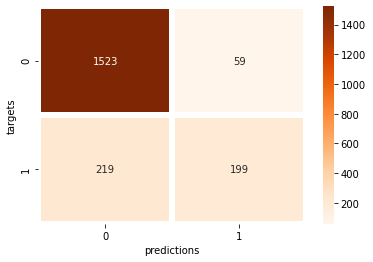

In [23]:
main_param(target_valid, predicted_valid_rfc)
print()
confusion_data(target_valid, predicted_valid_rfc)

recall_score 0.2344
precision_score 0.5632
f1_score 0.3311
AUC-ROC 0.5932



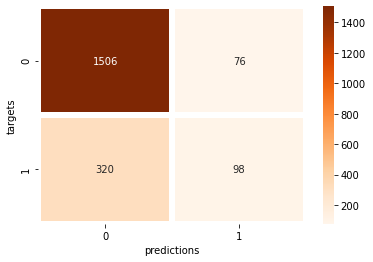

In [24]:
main_param(target_valid, predicted_valid_lgr)
print()
confusion_data(target_valid, predicted_valid_lgr)

**Вывод**

Мы получили модель, обученную алгоритмом Random Forest, с метрикой F1 на валидационной выборке равной 0.588.Модель плохо предсказывает положительные исходы. Причиной является дисбаланс классов в обучающей выборке.

## Борьба с дисбалансом

**Сбалансирование веса классов**

**Обучим алгоритм LogisticRegression**

In [25]:
model_blc_lgr = LogisticRegression(random_state=12345,
                                   solver='liblinear',
                                   class_weight='balanced')
model_blc_lgr.fit(features_train, target_train)
predicted_blc_lgr = model_blc_lgr.predict(features_valid)

recall_score 0.6818
precision_score 0.381
f1_score 0.4889
AUC-ROC 0.6946



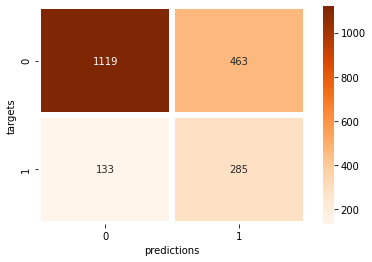

In [26]:
main_param(target_valid, predicted_blc_lgr)
print()
confusion_data(target_valid, predicted_blc_lgr)

Сбалансирование веса увеличило F1 модели Logistic Regression до 0.4889.

In [27]:
model_blc_rfc = RandomForestClassifier(random_state=12345,
                                       class_weight='balanced')
model_blc_rfc.fit(features_train, target_train)
predicted_blc_rfc = model_blc_rfc.predict(features_valid)
result_rfc = f1_score(target_valid, predicted_blc_rfc)

recall_score 0.4378
precision_score 0.7957
f1_score 0.5648
AUC-ROC 0.704



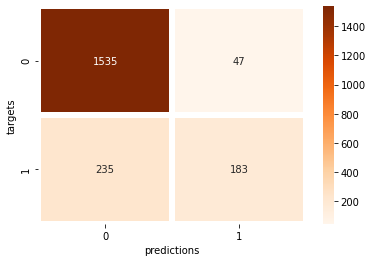

In [28]:
main_param(target_valid, predicted_blc_rfc)
print()
confusion_data(target_valid, predicted_blc_rfc)

Максимальное значение F1 0.5719 у модели случайного леса

In [29]:
scores['Classweighted'] = result_rfc

**Увеличение выборки**

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat(
        [features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat(
        [target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [31]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)
print(
    f'После увеличение выборки\n{target_upsampled.value_counts(normalize=True)}'
)

(9588, 11)
(9588,)
После увеличение выборки
0   0.50
1   0.50
Name: exited, dtype: float64


**Random Forest**

In [32]:
model_rfc = RandomForestClassifier(random_state=12345,
                                               n_estimators=91,
                                               max_depth=22)
model_rfc.fit(features_upsampled, target_upsampled)
predicted_up_rfc = model_rfc.predict(features_valid)
result_rfc = f1_score(target_valid, predicted_up_rfc)

recall_score 0.5455
precision_score 0.6533
f1_score 0.5945
AUC-ROC 0.7345



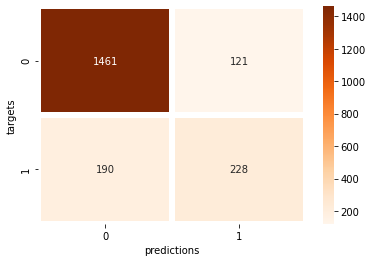

In [33]:
main_param(target_valid, predicted_up_rfc)
print()
confusion_data(target_valid, predicted_up_rfc)

F1 модели, обученной на увеличенной выборке, вырос до 0.5945, но не сильно высоко.

**LogisticRegression**

In [34]:
model = LogisticRegression(random_state = 12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_up = model.predict(features_valid)

recall_score 0.6818
precision_score 0.381
f1_score 0.4889
AUC-ROC 0.6946



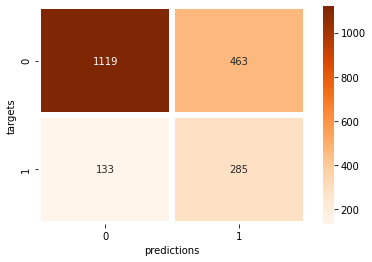

In [35]:
main_param(target_valid, predicted_up)
print()
confusion_data(target_valid, predicted_up)

Модель, обученная алгоритмом Logistic Regression, увеличила метрику F1 до 0.4889. Но для поставленной задачи это слишком мало.

In [36]:
scores['Upsampled'] = result_rfc

**Уменьшение выборки**

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] +
        [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] +
        [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled,
                                                       target_downsampled,
                                                       random_state=12345)

    return features_downsampled, target_downsampled

In [38]:
features_downsampled, target_downsampled = downsample(features_train,
                                                      target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)
print(
    f'После уменьшения выборки\n{target_downsampled.value_counts(normalize=True)}'
)

(2397, 11)
(2397,)
После уменьшения выборки
0   0.50
1   0.50
Name: exited, dtype: float64


Число объектов в обучающей выборке уменьшилось более чем вдвое - 2397, а классы оказались сбалансированны. Обучим модели на новых данных.

**Random Forest**

In [39]:
model_rfc = RandomForestClassifier(random_state=12345,
                                               n_estimators=91,
                                               max_depth=22)
model_rfc.fit(features_downsampled, target_downsampled)
predicted_down_rfc = model_rfc.predict(features_valid)
result_rfc = f1_score(target_valid, predicted_down_rfc)

recall_score 0.7512
precision_score 0.4729
f1_score 0.5804
AUC-ROC 0.765



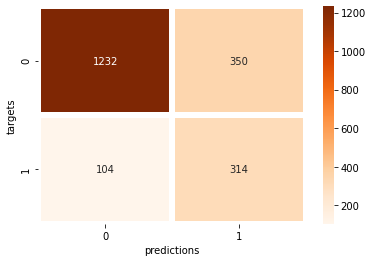

In [40]:
main_param(target_valid, predicted_down_rfc)
print()
confusion_data(target_valid, predicted_down_rfc)

**LogisticRegression**

In [41]:
model = LogisticRegression(random_state = 12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_down_lgr = model.predict(features_valid)
f1_up = f1_score(target_valid, predicted_down_lgr)

recall_score 0.6722
precision_score 0.3782
f1_score 0.4841
AUC-ROC 0.6901



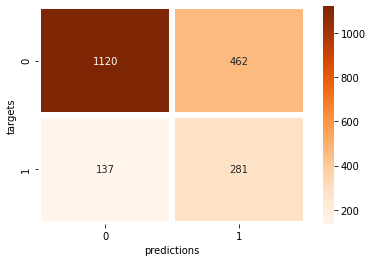

In [42]:
main_param(target_valid, predicted_down_lgr)
print()
confusion_data(target_valid, predicted_down_lgr)

In [43]:
scores['Downsampled'] = result_rfc

При обучении на уменьшенной выборке метрики F1 оказались немного ниже, чем на увеличенной. Logistic Regression дает результаты не лучше, чем Random Forest и хуже, чем заявленно в требованиях. Далее мы будем работать с алгоритмом Random Forest.

**Изменение порога вероятности**

Попробуем изменить порог вероятности положительного класса и посмотрим как разные варианты влияют на метрики модели. За алгорит обучения принимаем Random Forest, с гиперпараметрами, полученными при обучении с увеличенной выборке. Обучать модель будем на увеличенной выборке. Порог вероятности будем изменять от 0.2 до 0.6.

In [44]:
model_rfc.fit(features_upsampled, target_upsampled)
probabilities_valid = model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.2, 0.6, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    result_rfc = f1_score(target_valid, predicted_valid)
    
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:,.4f}"
          .format(threshold, precision, recall, result_rfc ))

Порог = 0.20 | Точность = 0.391, Полнота = 0.818, F1 = 0.5294
Порог = 0.22 | Точность = 0.412, Полнота = 0.785, F1 = 0.5404
Порог = 0.24 | Точность = 0.422, Полнота = 0.778, F1 = 0.5471
Порог = 0.26 | Точность = 0.442, Полнота = 0.754, F1 = 0.5570
Порог = 0.28 | Точность = 0.465, Полнота = 0.734, F1 = 0.5696
Порог = 0.30 | Точность = 0.476, Полнота = 0.715, F1 = 0.5717
Порог = 0.32 | Точность = 0.500, Полнота = 0.699, F1 = 0.5828
Порог = 0.34 | Точность = 0.517, Полнота = 0.687, F1 = 0.5899
Порог = 0.36 | Точность = 0.550, Полнота = 0.675, F1 = 0.6058
Порог = 0.38 | Точность = 0.571, Полнота = 0.658, F1 = 0.6111
Порог = 0.40 | Точность = 0.582, Полнота = 0.629, F1 = 0.6046
Порог = 0.42 | Точность = 0.605, Полнота = 0.608, F1 = 0.6062
Порог = 0.44 | Точность = 0.618, Полнота = 0.596, F1 = 0.6066
Порог = 0.46 | Точность = 0.633, Полнота = 0.581, F1 = 0.6060
Порог = 0.48 | Точность = 0.641, Полнота = 0.565, F1 = 0.6005
Порог = 0.50 | Точность = 0.653, Полнота = 0.545, F1 = 0.5945
Порог = 

Максимальная F1 равна 0.6111, приходится на порог 0.38.

Построим график ошибок модели, отметим на ней кривую для случайной модели.

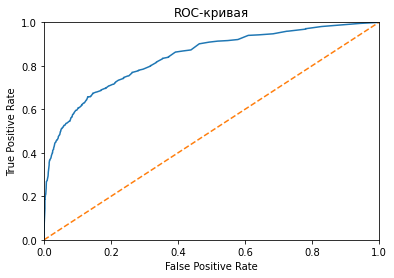

AUC-ROC = 0.8402


In [45]:
probabilities_valid = model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC = {:,.4f}'.format(auc_roc))

Максимальная F1 равна 0.6111, при пороге положительной вероятности 0.38. Полученная модель имеет хорошие предсказательные качества. Исследуем модель на тестовой выборке.Высокое значение метрики AUC-ROC подтверждает качество модели.

## Тестирование модели

In [46]:
model_rfc = RandomForestClassifier(random_state=12345,
                                               n_estimators=91,
                                               max_depth=22)
model_rfc.fit(features_upsampled, target_upsampled)
predicted_valid = model_rfc.predict(features_test)
result_rfc = f1_score(target_test, predicted_valid)


recall_score 0.5343
precision_score 0.6551
f1_score 0.5885
AUC-ROC 0.7294


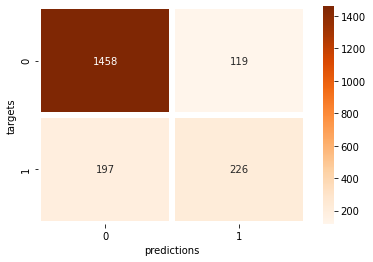

In [47]:
confusion_data(target_test,predicted_valid)
print()
main_param(target_test, predicted_valid)

In [48]:
scores['Test'] = result_rfc

In [49]:
scores

{'Unbalanced': 0.5887573964497042,
 'Classweighted': 0.5648148148148148,
 'Upsampled': 0.5945241199478488,
 'Downsampled': 0.5804066543438077,
 'Test': 0.5885416666666666}

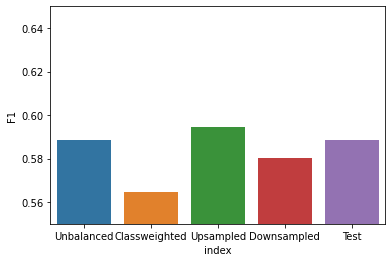

In [50]:
scores_df = pd.DataFrame(data=scores, index=['F1']).T.reset_index()
sns.barplot(x='index', y='F1', data=scores_df)
plt.ylim(0.55, 0.65);

**Вывод**

Целевой признак в исходном наборе данных оказался несбалансирован - один класс встречался гораздо чаще, чем другой. Малое число объектов одного класса приводит к тому, что модель недообучается распознавать этот класс. В работе был применен ряд методов, выравнивающих наличие классов в выборке:

- балансировка весов;
- увеличение выборки с редким классом;
- уменьшение выборки с частым классом.

Лучший результат дал метод увеличения выборки. Он позволил модели более полно обучиться распознавать оба класса. Выбор типа модели производился из двух вариантов: линейной регрессии и случайного леса. Лучшие значения метрики F1 показала модель случайного леса.

В результате была получена модель случайного леса с настроенными гиперпараметрами. Модель была обучена на увеличенной выборке. Предсказания выполненные на тестовой выборке оценены метрикой F1 равной 0.59. Полученную модель можно использовать для дальнейшей разработки предсказательной системы.